This code is a result of a recent research on portfolio theory. One can see the paper

 ***Halidias, Nikolaos. "A novel portfolio optimization method and its application to the hedging problem" Monte Carlo Methods and Applications, vol. 30, no. 3, 2024, pp. 249-267,*** and the references therein. (https://www.degruyterbrill.com/document/doi/10.1515/mcma-2024-2009/html)

See also the book
***Halidias, Nikolaos and Stamatiou, Ioannis S.. Stochastic Analysis: Financial Mathematics with Matlab®, De Gruyter, 2026.*** (https://www.degruyterbrill.com/document/isbn/9783111443737/html?lang=en&srsltid=AfmBOorukbLCPRdRPn2Mu2kqSWiGttsEAPF6wBfVNixx4fAFzxycr6Fl)

and the book ***Halidias, Nikolaos, Financial Engineering with Python*** (https://www.researchgate.net/publication/394413705_Financial_Engineering_with_Python?_tp=eyJjb250ZXh0Ijp7InBhZ2UiOiJwcm9maWxlIiwicHJldmlvdXNQYWdlIjoiaG9tZSIsInBvc2l0aW9uIjoicGFnZUNvbnRlbnQifX0).

At the webpage of the ***Actuarial-Financial Laboratory*** https://www.samos.aegean.gr/actuar/nick/actfinlabeng.htm one can find also other useful informations.



We use all the call and put options from the yahoo finace in order to construct the portfolio. If you choose experiment=1 then we use the lastPrices otherwise the bid-ask prices. If for any reason you want to take account only some of the call and put options you should manually set the data stock_value, call_strikes,put_strikes,call_ask,call_bid,put_ask,put_bid.



The payoff of the option should have finite number of branches where the last branch should be a linear function. You should find the slope of the last branch and all the points that changes branch.


We compute the set of arbitrage free prices and the fair and arbitrage free price $Y^{D^*}$ as this has been proposed at the above paper. Though we can propose several fair prices this fair price is the only one which is also arbitrage free for sure. Therefore this price can be seen as the unique fair and arbitrage free price in some sense.

In practice, before the expiration you should have:

1.   The amount 100*strike price for each call you have bought
2.   100 shares for each call that you have sell
3.   100 shares for each put that you have bought
4.   The amount 100*strike price for each put that you have sell



If you want to download data from Yahoo finance you should set Data_given=1. Otherwise you should have an excel file from which the data will be stored.

In [8]:
import numpy as np


#############################################################################################################
# You should set the following data
Data_given=1 # Set 1 if you want to download data from Yahoo finance otherwise read data from excel file
Firm='HTZ'
ExpirationDate='2026-01-16'
excel_file='excel2_file.xlsx'
experiment=0 # Set 1 if you want to experiment. Then the lastPrices will be used otherwise the bid-ask prices
max_number_of_total_call_options_to_buy=40 # Maximum number of total call options  to buy
max_number_of_total_put_options_to_buy=40 # Maximum number of total put options to buy
max_number_of_total_call_options_to_sell=40 # Maximum number of total call options to sell
max_number_of_total_put_options_to_sell=40 # Maximum number of total put options to sell
max_number_of_call_options_to_buy=1  # the number of maximum number of call options of each strike to buy
max_number_of_put_options_to_buy=1 # the number of maximum number of put options of each strike to buy
max_number_of_call_options_to_sell=1 # the number of maximum number of call options of each strike to sell
max_number_of_put_options_to_sell=1 # the number of maximum number of put options of each strike to sell
max_number_of_shares_to_buy=100
max_number_of_shares_to_sell=100
max_amount_to_bank_account=100
max_amount_from_bank_account=100
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
# Give the following information for the new option
def payoff_function(x):
    return np.maximum(x-5.2,0)
derivative_of_payoff=1
payoff_nodes=np.array([[5.2]])
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
###################################################################################################################


We define next the two functions $D^{writer}(Y)$ and $D^{buyer}(Y)$.

In [ ]:
def run_options_milp_writer(V):
    """
    Εκτελεί το MILP για κατασκευή/εύρεση θέσης σε options με ελαχιστοποίηση της μέγιστης ζημιάς.
    Παίρνει ΜΟΝΟ το V (ποσό στην εξίσωση κόστους). Όλες οι λοιπές παράμετροι/συναρτήσεις/δεδομένα
    πρέπει να έχουν οριστεί από άλλο cell στο global scope, π.χ.:

      Data_given, Firm, ExpirationDate, excel_file, experiment
      max_number_of_total_call_options_to_buy, max_number_of_total_put_options_to_buy,
      max_number_of_total_call_options_to_sell, max_number_of_total_put_options_to_sell,
      max_number_of_call_options_to_buy, max_number_of_put_options_to_buy,
      max_number_of_call_options_to_sell, max_number_of_put_options_to_sell,
      max_number_of_shares_to_buy, max_number_of_shares_to_sell,
      max_amount_to_bank_account, max_amount_from_bank_account,
      payoff_function(x), derivative_of_payoff (αριθμός), payoff_nodes (1-D array)

    Επιστρέφει dict με:
      - x: η λύση του προβλήματος
      - result: αντικείμενο SciPy milp result
      - tables: {'shares': PrettyTable, 'options': PrettyTable}
      - profit_function: callable(y) -> κέρδος
      - data: λεξικό εισόδων (τιμές μετοχής, strikes, bids/asks)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import LinearConstraint, Bounds, milp
    from prettytable import PrettyTable

    # --------- Έλεγχος ότι υπάρχουν οι αναμενόμενες global μεταβλητές ---------
    required_globals = [
        "Data_given", "Firm", "ExpirationDate", "excel_file", "experiment",
        "max_number_of_total_call_options_to_buy", "max_number_of_total_put_options_to_buy",
        "max_number_of_total_call_options_to_sell", "max_number_of_total_put_options_to_sell",
        "max_number_of_call_options_to_buy", "max_number_of_put_options_to_buy",
        "max_number_of_call_options_to_sell", "max_number_of_put_options_to_sell",
        "max_number_of_shares_to_buy", "max_number_of_shares_to_sell",
        "max_amount_to_bank_account", "max_amount_from_bank_account",
        "payoff_function", "derivative_of_payoff", "payoff_nodes"
    ]
    missing = [n for n in required_globals if n not in globals()]
    if missing:
        raise NameError(f"Λείπουν global μεταβλητές/συναρτήσεις: {missing}. "
                        f"Ορίστε τες πρώτα σε άλλο cell.")

    # --------- Βοηθητικές συναρτήσεις συλλογής δεδομένων ---------
    def options_bid_ask_yahoo(Firm, ExpirationDate, experiment):
        import yfinance as yt
        stock = yt.Ticker(Firm)

        hist = stock.history(period='1d')
        if hist is None or hist.empty:
            raise ValueError("Αδυναμία λήψης τελευταίας τιμής μετοχής από Yahoo.")

        stock_value = float(hist['Close'].iloc[-1])

        exps = list(stock.options) if stock.options is not None else []
        if not exps:
            raise ValueError("Δεν υπάρχουν διαθέσιμες λήξεις options στο Yahoo Finance.")

        # Αν η ζητούμενη λήξη δεν υπάρχει, πάρε την πρώτη διαθέσιμη
        if ExpirationDate not in exps:
            ExpirationDate = exps[0]

        chain = stock.option_chain(ExpirationDate)
        calls = chain.calls
        puts  = chain.puts

        call_strikes = calls['strike'].to_numpy(dtype=float)
        put_strikes  = puts['strike'].to_numpy(dtype=float)

        if experiment == 1:
            call_ask = calls['lastPrice'].fillna(0.0).to_numpy(dtype=float)
            call_bid = calls['lastPrice'].fillna(0.0).to_numpy(dtype=float)
            put_ask  = puts['lastPrice'].fillna(0.0).to_numpy(dtype=float)
            put_bid  = puts['lastPrice'].fillna(0.0).to_numpy(dtype=float)
        else:
            call_ask = calls['ask'].fillna(0.0).to_numpy(dtype=float)
            call_bid = calls['bid'].fillna(0.0).to_numpy(dtype=float)
            put_ask  = puts['ask'].fillna(0.0).to_numpy(dtype=float)
            put_bid  = puts['bid'].fillna(0.0).to_numpy(dtype=float)

        return stock_value, call_strikes, put_strikes, call_ask, call_bid, put_ask, put_bid

    def options_bid_ask_excel(experiment):
        import pandas as pd
        df = pd.read_excel(excel_file)

        # Map στηριγμένο στη διάταξη που χρησιμοποιούσατε:
        # 0: stock_value, 1: call_strike, 2: call_last, 3: call_bid, 4: call_ask,
        # 5: put_strike,  6: put_last,  7: put_bid,  8: put_ask
        df = df.rename(columns={
            df.columns[0]: "stock_value",
            df.columns[1]: "call_strike",
            df.columns[2]: "call_last",
            df.columns[3]: "call_bid",
            df.columns[4]: "call_ask",
            df.columns[5]: "put_strike",
            df.columns[6]: "put_last",
            df.columns[7]: "put_bid",
            df.columns[8]: "put_ask",
        })

        stock_value = float(df.loc[0, "stock_value"])

        call_df = df.loc[:, ["call_strike", "call_ask", "call_bid", "call_last"]].dropna(subset=["call_strike"])
        put_df  = df.loc[:, ["put_strike",  "put_ask",  "put_bid",  "put_last"]].dropna(subset=["put_strike"])

        if experiment == 1:
            call_df["call_ask"] = call_df["call_last"]
            call_df["call_bid"] = call_df["call_last"]
            put_df["put_ask"]   = put_df["put_last"]
            put_df["put_bid"]   = put_df["put_last"]

        call_df = call_df.dropna(subset=["call_ask", "call_bid"])
        put_df  = put_df.dropna(subset=["put_ask",  "put_bid"])

        call_strikes = call_df["call_strike"].to_numpy(dtype=float)
        call_ask     = call_df["call_ask"].to_numpy(dtype=float)
        call_bid     = call_df["call_bid"].to_numpy(dtype=float)

        put_strikes  = put_df["put_strike"].to_numpy(dtype=float)
        put_ask      = put_df["put_ask"].to_numpy(dtype=float)
        put_bid      = put_df["put_bid"].to_numpy(dtype=float)

        return stock_value, call_strikes, put_strikes, call_ask, call_bid, put_ask, put_bid

    # --------- Ανάκτηση δεδομένων (Yahoo ή Excel) ---------
    if Data_given == 1:
        stock_value, call_strikes, put_strikes, call_ask1, call_bid, put_ask1, put_bid = options_bid_ask_yahoo(
            Firm, ExpirationDate, experiment
        )
    else:
        stock_value, call_strikes, put_strikes, call_ask1, call_bid, put_ask1, put_bid = options_bid_ask_excel(
            experiment
        )

    # --------- Φιλτράρισμα μηδενικών ask και ευθυγράμμιση ---------
    keep_call = (call_ask1 != 0)
    keep_put  = (put_ask1  != 0)

    call_strikes = call_strikes[keep_call]
    call_ask     = call_ask1[keep_call]
    call_bid     = call_bid[keep_call]

    put_strikes  = put_strikes[keep_put]
    put_ask      = put_ask1[keep_put]
    put_bid      = put_bid[keep_put]

    if call_ask.size == 0 and put_ask.size == 0:
        raise ValueError("Δεν βρέθηκαν συμβόλαια με μη μηδενικά ask μετά το φιλτράρισμα.")

    # --------- Ένωση strikes με κόμβους payoff ---------
    payoff_nodes_arr = np.array(payoff_nodes, dtype=float).ravel()
    union_strikes = np.union1d(np.union1d(call_strikes, put_strikes), payoff_nodes_arr)
    max_element = float(union_strikes.max()) if union_strikes.size else 0.0

    # --------- Δείκτες μεταβλητών (για καθαρό indexing) ---------
    nC = len(call_strikes)
    nP = len(put_strikes)
    idx_shares   = 0
    idx_bank     = 1
    idx_cbuy     = slice(2, 2 + nC)
    idx_csell    = slice(2 + nC, 2 + 2*nC)
    idx_pbuy     = slice(2 + 2*nC, 2 + 2*nC + nP)
    idx_psell    = slice(2 + 2*nC + nP, 2 + 2*nC + 2*nP)
    idx_maxloss  = 2 + 2*nC + 2*nP

    # --------- Συνάρτηση που δίνει τη γραμμή του πίνακα PP(x) ---------
    def PP(x):
        x = float(x)
        row = np.maximum(x - call_strikes, 0.0)                 # calls buy
        row = np.append(row, -np.maximum(x - call_strikes, 0.0))# calls sell
        row = np.append(row, np.maximum(put_strikes - x, 0.0))  # puts buy
        row = np.append(row, -np.maximum(put_strikes - x, 0.0)) # puts sell
        row = np.append(1.0, row)                               # bank
        row = np.append(x, row)                                 # shares
        row = np.append(row, 1.0)                               # max loss var
        return row

    # --------- Πίνακας περιορισμών από PP στα union_strikes ---------
    AA = PP(0.0)
    for xi in union_strikes:
        AA = np.vstack([AA, PP(xi)])
    AA = -AA  # όπως στον αρχικό κώδικα
    number_of_columns_AA = AA.shape[1]
    assert number_of_columns_AA == (idx_maxloss + 1)

    # --------- Γραμμή παραγώγου payoff ---------
    Aderiv = np.zeros(number_of_columns_AA)
    Aderiv[idx_shares] = -1.0
    Aderiv[idx_cbuy]   = -1.0
    Aderiv[idx_csell]  = +1.0
    # bank/puts/maxloss -> 0
    AA = np.vstack([AA, Aderiv])

    # --------- Γραμμή εξίσωσης κόστους ---------
    Aequality = np.zeros(number_of_columns_AA)
    Aequality[idx_shares] = stock_value
    Aequality[idx_bank]   = 1.0
    Aequality[idx_cbuy]   = call_ask
    Aequality[idx_csell]  = -call_bid
    Aequality[idx_pbuy]   = put_ask
    Aequality[idx_psell]  = -put_bid
    # maxloss -> 0
    AA = np.vstack([AA, Aequality])

    # --------- Γραμμές μέγιστου πλήθους options ---------
    Amax_cbuy  = np.zeros(number_of_columns_AA);  Amax_cbuy[idx_cbuy]  = 1.0
    Amax_csell = np.zeros(number_of_columns_AA);  Amax_csell[idx_csell] = 1.0
    Amax_pbuy  = np.zeros(number_of_columns_AA);  Amax_pbuy[idx_pbuy]  = 1.0
    Amax_psell = np.zeros(number_of_columns_AA);  Amax_psell[idx_psell] = 1.0

    AA = np.vstack([AA, Amax_cbuy, Amax_csell, Amax_pbuy, Amax_psell])

    # --------- Δεξιά μέλη b / bl ---------
    n_payoff_rows = 1 + len(union_strikes)  # (x=0) + κάθε union_strike
    total_rows = n_payoff_rows + 1 + 1 + 4  # + derivative + cost + 4 max
    assert AA.shape[0] == total_rows

    b  = np.zeros(total_rows, dtype=float)
    bl = np.full(total_rows, -np.inf, dtype=float)

    # payoff rows
    b[0] = -float(np.squeeze(payoff_function(0.0)))
    for k, us in enumerate(union_strikes, start=1):
        b[k] = -float(np.squeeze(payoff_function(us)))

    # derivative row
    idx_deriv = n_payoff_rows
    b[idx_deriv] = -float(derivative_of_payoff)

    # cost equality row
    idx_cost = n_payoff_rows + 1
    b[idx_cost]  = float(V)
    bl[idx_cost] = float(V)

    # max numbers rows
    b[n_payoff_rows + 2] = float(max_number_of_total_call_options_to_buy)
    b[n_payoff_rows + 3] = float(max_number_of_total_call_options_to_sell)
    b[n_payoff_rows + 4] = float(max_number_of_total_put_options_to_buy)
    b[n_payoff_rows + 5] = float(max_number_of_total_put_options_to_sell)

    # --------- Όρια μεταβλητών ---------
    ub = np.zeros(number_of_columns_AA, dtype=float)
    lb = np.zeros(number_of_columns_AA, dtype=float)

    lb[idx_shares]  = -float(max_number_of_shares_to_sell)
    ub[idx_shares]  =  float(max_number_of_shares_to_buy)

    lb[idx_bank]    = -float(max_amount_from_bank_account)
    ub[idx_bank]    =  float(max_amount_to_bank_account)

    ub[idx_cbuy]    = float(max_number_of_call_options_to_buy)
    ub[idx_csell]   = float(max_number_of_call_options_to_sell)
    ub[idx_pbuy]    = float(max_number_of_put_options_to_buy)
    ub[idx_psell]   = float(max_number_of_put_options_to_sell)

    lb[idx_maxloss] = -np.inf
    ub[idx_maxloss] =  np.inf

    bounds = Bounds(lb, ub)

    # --------- Ακέραιες/συνεχείς μεταβλητές ---------
    integrality = np.ones(number_of_columns_AA, dtype=int)
    integrality[idx_shares]  = 0  # μετοχές ως συνεχής ποσότητα (ή βάλτε 1 αν τις θέλετε ακέραιες)
    integrality[idx_bank]    = 0  # τραπεζικός λογαριασμός συνεχής
    integrality[idx_maxloss] = 0  # μεταβλητή "max loss" συνεχής

    # --------- Αντικειμενική: ελαχιστοποίηση της max ζημιάς ---------
    c = np.zeros(number_of_columns_AA, dtype=float)
    c[idx_maxloss] = 1.0

    # --------- Λύση MILP ---------
    constraints = LinearConstraint(AA, bl, b)
    result = milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds)

    if result.status != 0:
        raise RuntimeError(f"MILP δεν συγκλίνει: {result.message}")

    x = result.x

    # --------- Πίνακες αποτελεσμάτων ---------
    t = PrettyTable(['Shares', 'Number of Shares', 'Price', 'Amount for Shares'])
    t.add_row([Firm, x[idx_shares], stock_value, x[idx_shares]*stock_value])

    tt = PrettyTable(['Type of Option', 'Strike Price', 'Number of Options', 'Price of each Option'])

    # Calls buy
    for j, k in enumerate(range(idx_cbuy.start, idx_cbuy.stop)):
        if x[k] > 0.01:
            tt.add_row(['Call', call_strikes[j], round(x[k]), call_ask[j]])
    # Calls sell
    for j, k in enumerate(range(idx_csell.start, idx_csell.stop)):
        if x[k] > 0.01:
            tt.add_row(['Call', call_strikes[j], -round(x[k]), call_bid[j]])
    # Puts buy
    for j, k in enumerate(range(idx_pbuy.start, idx_pbuy.stop)):
        if x[k] > 0.01:
            tt.add_row(['Put', put_strikes[j], round(x[k]), put_ask[j]])
    # Puts sell  (διορθωμένο indexing)
    for j, k in enumerate(range(idx_psell.start, idx_psell.stop)):
        if x[k] > 0.01:
            tt.add_row(['Put', put_strikes[j], -round(x[k]), put_bid[j]])

    tt.add_divider()
    tt.add_row(['Bank Account', '--', '--', x[idx_bank]])
    tt.add_divider()
    total_amount = float(Aequality @ x)  # πρέπει να ισούται με V
    tt.add_row(['Total amount', '--', '--', total_amount])
    tt._align['Number of Options'] = 'r'

   # print(t)
    #print(tt)


    import matplotlib.pyplot as plt
    # --------- Profit function & γράφημα ---------
    def profit_function_scalar(y):
        val = x[idx_shares]*y + x[idx_bank] - float(np.squeeze(payoff_function(y)))
        vec = PP(y)
        for k in range(2, idx_maxloss):
            if x[k] > 0.01:
                val += round(x[k]) * vec[k]
        return float(val)

    ymax = max_element * 2.2 if max_element > 0 else 1.0
    y_values = np.linspace(0.0, ymax, 500)
    profit_values = np.array([profit_function_scalar(y) for y in y_values])

    ax = plt.gca()
    ax.plot(y_values, profit_values)
    ax.set_xlabel("Stock Price")
    ax.set_ylabel("Profit")
    ax.set_title("Profit Function")
    ax.grid(True)
    ax.axhline(0, color='black', linewidth=1.5, linestyle='--')
    ax.fill_between(y_values, profit_values, 0,
                    where=(profit_values > 0), alpha=0.3, label='Περιοχή y > 0')
    ax.fill_between(y_values, profit_values, 0,
                    where=(profit_values < 0), alpha=0.3, label='Περιοχή y < 0')
    #plt.show()
    plt.close(plt.gcf())

    # The function was printing this value, but not returning it.
    # print(x[idx_maxloss])

    # --------- Επιστροπή αποτελεσμάτων ---------
    # return {
    #    "x": x,
    #    "result": result,
    #    "tables": {"shares": t, "options": tt},
    #    "profit_function": profit_function_scalar,
    #    "data": {
    #        "stock_value": stock_value,
    #        "call_strikes": call_strikes,
    #        "put_strikes": put_strikes,
    #        "call_ask": call_ask,
    #        "call_bid": call_bid,
    #        "put_ask": put_ask,
    #        "put_bid": put_bid,
    #        "union_strikes": union_strikes
    #    }
    # }
    return x[idx_maxloss] # Return the value that was previously printed.

In [ ]:
def run_options_milp_buyer(V):
    """
    MILP για κατασκευή/εύρεση θέσης σε options (εκδοχή με b = +payoff και κέρδος που ΠΡΟΣΘΕΤΕΙ payoff).
    Παίρνει ΜΟΝΟ το V. Όλα τα υπόλοιπα πρέπει να υπάρχουν ως globals από άλλο cell:

      Data_given, Firm, ExpirationDate, excel_file, experiment
      max_number_of_total_call_options_to_buy, max_number_of_total_put_options_to_buy,
      max_number_of_total_call_options_to_sell, max_number_of_total_put_options_to_sell,
      max_number_of_call_options_to_buy, max_number_of_put_options_to_buy,
      max_number_of_call_options_to_sell, max_number_of_put_options_to_sell,
      max_number_of_shares_to_buy, max_number_of_shares_to_sell,
      max_amount_to_bank_account, max_amount_from_bank_account,
      payoff_function(x), derivative_of_payoff, payoff_nodes (μπορεί να έχει πολλά σημεία)

    Επιστρέφει dict με:
      - x: λύση
      - result: SciPy milp result
      - tables: {'shares': PrettyTable, 'options': PrettyTable}
      - profit_function: callable(y) -> κέρδος
      - data: λεξικό δεδομένων (τιμές μετοχής, strikes, bids/asks, union_strikes)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import LinearConstraint, Bounds, milp
    from prettytable import PrettyTable

    # -------- Έλεγχος globals --------
    required_globals = [
        "Data_given", "Firm", "ExpirationDate", "excel_file", "experiment",
        "max_number_of_total_call_options_to_buy", "max_number_of_total_put_options_to_buy",
        "max_number_of_total_call_options_to_sell", "max_number_of_total_put_options_to_sell",
        "max_number_of_call_options_to_buy", "max_number_of_put_options_to_buy",
        "max_number_of_call_options_to_sell", "max_number_of_put_options_to_sell",
        "max_number_of_shares_to_buy", "max_number_of_shares_to_sell",
        "max_amount_to_bank_account", "max_amount_from_bank_account",
        "payoff_function", "derivative_of_payoff", "payoff_nodes"
    ]
    missing = [n for n in required_globals if n not in globals()]
    if missing:
        raise NameError(f"Λείπουν global μεταβλητές/συναρτήσεις: {missing}. Ορίστε τες πρώτα σε άλλο cell.")

    # -------- Βοηθητικές: Yahoo / Excel --------
    def options_bid_ask_yahoo(Firm, ExpirationDate, experiment):
        import yfinance as yt
        stock = yt.Ticker(Firm)

        hist = stock.history(period='1d')
        if hist is None or hist.empty:
            raise ValueError("Αδυναμία λήψης τελευταίας τιμής μετοχής από Yahoo.")
        stock_value = float(hist['Close'].iloc[-1])

        exps = list(stock.options) if getattr(stock, "options", None) is not None else []
        if not exps:
            raise ValueError("Δεν υπάρχουν διαθέσιμες λήξεις options στο Yahoo Finance.")
        if ExpirationDate not in exps:
            ExpirationDate = exps[0]  # fallback σε διαθέσιμη λήξη

        chain = stock.option_chain(ExpirationDate)
        calls, puts = chain.calls, chain.puts

        call_strikes = calls['strike'].to_numpy(dtype=float)
        put_strikes  = puts['strike'].to_numpy(dtype=float)

        if experiment == 1:
            call_ask = calls['lastPrice'].fillna(0.0).to_numpy(dtype=float)
            call_bid = calls['lastPrice'].fillna(0.0).to_numpy(dtype=float)
            put_ask  = puts['lastPrice'].fillna(0.0).to_numpy(dtype=float)
            put_bid  = puts['lastPrice'].fillna(0.0).to_numpy(dtype=float)
        else:
            call_ask = calls['ask'].fillna(0.0).to_numpy(dtype=float)
            call_bid = calls['bid'].fillna(0.0).to_numpy(dtype=float)
            put_ask  = puts['ask'].fillna(0.0).to_numpy(dtype=float)
            put_bid  = puts['bid'].fillna(0.0).to_numpy(dtype=float)

        return stock_value, call_strikes, put_strikes, call_ask, call_bid, put_ask, put_bid

    def options_bid_ask_excel(experiment):
        import pandas as pd
        df = pd.read_excel(excel_file)

        # mapping σύμφωνα με το αρχικό layout:
        # 0: stock_value, 1: call_strike, 2: call_last, 3: call_bid, 4: call_ask,
        # 5: put_strike,  6: put_last,  7: put_bid,  8: put_ask
        df = df.rename(columns={
            df.columns[0]: "stock_value",
            df.columns[1]: "call_strike",
            df.columns[2]: "call_last",
            df.columns[3]: "call_bid",
            df.columns[4]: "call_ask",
            df.columns[5]: "put_strike",
            df.columns[6]: "put_last",
            df.columns[7]: "put_bid",
            df.columns[8]: "put_ask",
        })

        stock_value = float(df.loc[0, "stock_value"])

        call_df = df.loc[:, ["call_strike", "call_ask", "call_bid", "call_last"]].dropna(subset=["call_strike"])
        put_df  = df.loc[:, ["put_strike",  "put_ask",  "put_bid",  "put_last"]].dropna(subset=["put_strike"])

        if experiment == 1:
            call_df["call_ask"] = call_df["call_last"]
            call_df["call_bid"] = call_df["call_last"]
            put_df["put_ask"]   = put_df["put_last"]
            put_df["put_bid"]   = put_df["put_last"]

        call_df = call_df.dropna(subset=["call_ask", "call_bid"])
        put_df  = put_df.dropna(subset=["put_ask", "put_bid"])

        call_strikes = call_df["call_strike"].to_numpy(dtype=float)
        call_ask     = call_df["call_ask"].to_numpy(dtype=float)
        call_bid     = call_df["call_bid"].to_numpy(dtype=float)

        put_strikes  = put_df["put_strike"].to_numpy(dtype=float)
        put_ask      = put_df["put_ask"].to_numpy(dtype=float)
        put_bid      = put_df["put_bid"].to_numpy(dtype=float)

        return stock_value, call_strikes, put_strikes, call_ask, call_bid, put_ask, put_bid

    # -------- Δεδομένα --------
    if Data_given == 1:
        stock_value, call_strikes, put_strikes, call_ask1, call_bid, put_ask1, put_bid = options_bid_ask_yahoo(
            Firm, ExpirationDate, experiment
        )
    else:
        stock_value, call_strikes, put_strikes, call_ask1, call_bid, put_ask1, put_bid = options_bid_ask_excel(
            experiment
        )

    # -------- Φίλτρο μηδενικών ask --------
    keep_call = (call_ask1 != 0)
    keep_put  = (put_ask1  != 0)

    call_strikes = call_strikes[keep_call]
    call_ask     = call_ask1[keep_call]
    call_bid     = call_bid[keep_call]

    put_strikes  = put_strikes[keep_put]
    put_ask      = put_ask1[keep_put]
    put_bid      = put_bid[keep_put]

    if call_ask.size == 0 and put_ask.size == 0:
        raise ValueError("Δεν βρέθηκαν συμβόλαια με μη μηδενικά ask μετά το φιλτράρισμα.")

    # -------- Ένωση strikes + κόμβοι payoff (1-D!) --------
    payoff_nodes_arr = np.array(payoff_nodes, dtype=float).ravel()
    union_strikes = np.union1d(np.union1d(call_strikes, put_strikes), payoff_nodes_arr)
    max_element = float(union_strikes.max()) if union_strikes.size else 0.0

    # -------- Δείκτες μεταβλητών --------
    nC = len(call_strikes)
    nP = len(put_strikes)
    idx_shares   = 0
    idx_bank     = 1
    idx_cbuy     = slice(2, 2 + nC)
    idx_csell    = slice(2 + nC, 2 + 2*nC)
    idx_pbuy     = slice(2 + 2*nC, 2 + 2*nC + nP)
    idx_psell    = slice(2 + 2*nC + nP, 2 + 2*nC + 2*nP)
    idx_maxloss  = 2 + 2*nC + 2*nP

    # -------- Γραμμή PP(x) --------
    def PP(x):
        x = float(x)
        row = np.maximum(x - call_strikes, 0.0)                  # calls buy
        row = np.append(row, -np.maximum(x - call_strikes, 0.0)) # calls sell
        row = np.append(row, np.maximum(put_strikes - x, 0.0))   # puts buy
        row = np.append(row, -np.maximum(put_strikes - x, 0.0))  # puts sell
        row = np.append(1.0, row)                                # bank
        row = np.append(x, row)                                  # shares
        row = np.append(row, 1.0)                                # max loss var
        return row

    # -------- Πίνακας AA από PP --------
    AA = PP(0.0)
    for xi in union_strikes:
        AA = np.vstack([AA, PP(xi)])
    AA = -AA
    number_of_columns_AA = AA.shape[1]

    # -------- Παράγωγος payoff (όπως στο δεύτερο script: +derivative) --------
    Aderiv = np.zeros(number_of_columns_AA)
    Aderiv[idx_shares] = -1.0
    Aderiv[idx_cbuy]   = -1.0
    Aderiv[idx_csell]  = +1.0
    AA = np.vstack([AA, Aderiv])

    # -------- Εξίσωση κόστους --------
    Aequality = np.zeros(number_of_columns_AA)
    Aequality[idx_shares] = stock_value
    Aequality[idx_bank]   = 1.0
    Aequality[idx_cbuy]   = call_ask
    Aequality[idx_csell]  = -call_bid
    Aequality[idx_pbuy]   = put_ask
    Aequality[idx_psell]  = -put_bid
    AA = np.vstack([AA, Aequality])

    # -------- Μέγιστο πλήθος options --------
    Amax_cbuy  = np.zeros(number_of_columns_AA);  Amax_cbuy[idx_cbuy]   = 1.0
    Amax_csell = np.zeros(number_of_columns_AA);  Amax_csell[idx_csell] = 1.0
    Amax_pbuy  = np.zeros(number_of_columns_AA);  Amax_pbuy[idx_pbuy]   = 1.0
    Amax_psell = np.zeros(number_of_columns_AA);  Amax_psell[idx_psell] = 1.0
    AA = np.vstack([AA, Amax_cbuy, Amax_csell, Amax_pbuy, Amax_psell])

    # -------- Δεξιά μέλη b / bl (ΣΗΜΕΙΑΚΑ ΟΠΩΣ ΣΤΟ ΔΕΥΤΕΡΟ SCRIPT: +payoff) --------
    n_payoff_rows = 1 + len(union_strikes)  # (x=0) + κάθε union_strike
    total_rows = n_payoff_rows + 1 + 1 + 4  # + derivative + cost + 4 max
    assert AA.shape[0] == total_rows

    b  = np.zeros(total_rows, dtype=float)
    bl = np.full(total_rows, -np.inf, dtype=float)

    # payoff rows (θετικό πρόσημο)
    b[0] = float(np.squeeze(payoff_function(0.0)))
    for k, us in enumerate(union_strikes, start=1):
        b[k] = float(np.squeeze(payoff_function(us)))

    # derivative row (θετικό όπως δίνεται)
    idx_deriv = n_payoff_rows
    b[idx_deriv] = float(derivative_of_payoff)

    # cost equality row
    idx_cost = n_payoff_rows + 1
    b[idx_cost]  = float(V)
    bl[idx_cost] = float(V)

    # max numbers rows
    b[n_payoff_rows + 2] = float(max_number_of_total_call_options_to_buy)
    b[n_payoff_rows + 3] = float(max_number_of_total_call_options_to_sell)
    b[n_payoff_rows + 4] = float(max_number_of_total_put_options_to_buy)
    b[n_payoff_rows + 5] = float(max_number_of_total_put_options_to_sell)

    # -------- Όρια μεταβλητών --------
    ub = np.zeros(number_of_columns_AA, dtype=float)
    lb = np.zeros(number_of_columns_AA, dtype=float)

    lb[idx_shares]  = -float(max_number_of_shares_to_sell)
    ub[idx_shares]  =  float(max_number_of_shares_to_buy)

    lb[idx_bank]    = -float(max_amount_from_bank_account)
    ub[idx_bank]    =  float(max_amount_to_bank_account)

    ub[idx_cbuy]    = float(max_number_of_call_options_to_buy)
    ub[idx_csell]   = float(max_number_of_call_options_to_sell)
    ub[idx_pbuy]    = float(max_number_of_put_options_to_buy)
    ub[idx_psell]   = float(max_number_of_put_options_to_sell)

    lb[idx_maxloss] = -np.inf
    ub[idx_maxloss] =  np.inf

    bounds = Bounds(lb, ub)

    # -------- Ακεραιότητες --------
    integrality = np.ones(number_of_columns_AA, dtype=int)
    integrality[idx_shares]  = 0
    integrality[idx_bank]    = 0
    integrality[idx_maxloss] = 0

    # -------- Αντικειμενική --------
    c = np.zeros(number_of_columns_AA, dtype=float)
    c[idx_maxloss] = 1.0

    # -------- Λύση MILP --------
    constraints = LinearConstraint(AA, bl, b)
    result = milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds)
    if result.status != 0:
        raise RuntimeError(f"MILP δεν συγκλίνει: {result.message}")
    x = result.x

    # -------- Πίνακες αποτελεσμάτων --------
    t = PrettyTable(['Shares', 'Number of Shares', 'Price', 'Amount for Shares'])
    t.add_row([Firm, x[idx_shares], stock_value, x[idx_shares]*stock_value])

    tt = PrettyTable(['Type of Option', 'Strike Price', 'Number of Options', 'Price of each Option'])

    # Calls buy
    for j, k in enumerate(range(idx_cbuy.start, idx_cbuy.stop)):
        if x[k] > 0.01:
            tt.add_row(['Call', call_strikes[j], round(x[k]), call_ask[j]])
    # Calls sell
    for j, k in enumerate(range(idx_csell.start, idx_csell.stop)):
        if x[k] > 0.01:
            tt.add_row(['Call', call_strikes[j], -round(x[k]), call_bid[j]])
    # Puts buy
    for j, k in enumerate(range(idx_pbuy.start, idx_pbuy.stop)):
        if x[k] > 0.01:
            tt.add_row(['Put', put_strikes[j], round(x[k]), put_ask[j]])
    # Puts sell (διορθωμένο indexing)
    for j, k in enumerate(range(idx_psell.start, idx_psell.stop)):
        if x[k] > 0.01:
            tt.add_row(['Put', put_strikes[j], -round(x[k]), put_bid[j]])

    tt.add_divider()
    tt.add_row(['Bank Account', '--', '--', x[idx_bank]])
    tt.add_divider()
    total_amount = float(Aequality @ x)  # πρέπει να ισούται με V
    tt.add_row(['Total amount', '--', '--', total_amount])
    tt._align['Number of Options'] = 'r'

   # print(t)
   # print(tt)

    # -------- Κέρδος (ΠΡΟΣΘΕΤΕΙ payoff, όπως στο δεύτερο script) --------
    def profit_function_scalar(y):
        val = x[idx_shares]*y + x[idx_bank] + float(np.squeeze(payoff_function(y)))
        vec = PP(y)
        for k in range(2, idx_maxloss):
            if x[k] > 0.01:
                val += round(x[k]) * vec[k]
        return float(val)


    import matplotlib.pyplot as plt
    # -------- Γράφημα --------
    ymax = max_element * 2.2 if max_element > 0 else 1.0
    y_values = np.linspace(0.0, ymax, 500)
    profit_values = np.array([profit_function_scalar(y) for y in y_values])

    ax = plt.gca()
    ax.plot(y_values, profit_values)
    ax.set_xlabel("Stock Price")
    ax.set_ylabel("Profit")
    ax.set_title("Profit Function")
    ax.grid(True)
    ax.axhline(0, color='black', linewidth=1.5, linestyle='--')
    ax.fill_between(y_values, profit_values, 0, where=(profit_values > 0), alpha=0.3, label='Περιοχή y > 0')
    ax.fill_between(y_values, profit_values, 0, where=(profit_values < 0), alpha=0.3, label='Περιοχή y < 0')
   # plt.show()


    plt.close(plt.gcf())
    # The function was printing this value, but not returning it.
    # print(x[idx_maxloss])


    #return {
     #   "x": x,
      #  "result": result,
       # "tables": {"shares": t, "options": tt},
       # "profit_function": profit_function_scalar,
       # "data": {
        #    "stock_value": stock_value,
        #    "call_strikes": call_strikes,
         #   "put_strikes": put_strikes,
         #   "call_ask": call_ask,
         #   "call_bid": call_bid,
          #  "put_ask": put_ask,
         #   "put_bid": put_bid,
          #  "union_strikes": union_strikes
       # }
  #  }
    return x[idx_maxloss] # Return the value that was previously printed.

At the function $D^{writer}$ the amount $Y$ should be positive.

In [ ]:
run_options_milp_writer(1.25)

0.04999999999996779


At the function $D^{buyer}$ the amount $Y$ should be negative.

In [ ]:
run_options_milp_buyer(-1.25)

0.049999904632569585



Note that $Y^{writer}=e^{-rT} D^{writer}(0)$ and $Y^{buyer}=-e^{-rT} D^{buyer}(0)$. So it is easy to compute the arbitrage free interval, if any.

The fair value $Y^{D^*} = e^{-rT} \frac{D^{writer}(0)-D^{buyer}(0)}{2}$ and $D^* = \frac{D^{writer}(0)+D^{buyer}(0)}{2}$.



Below we compute the values of these functions for several amount $Y$ and print their graph.


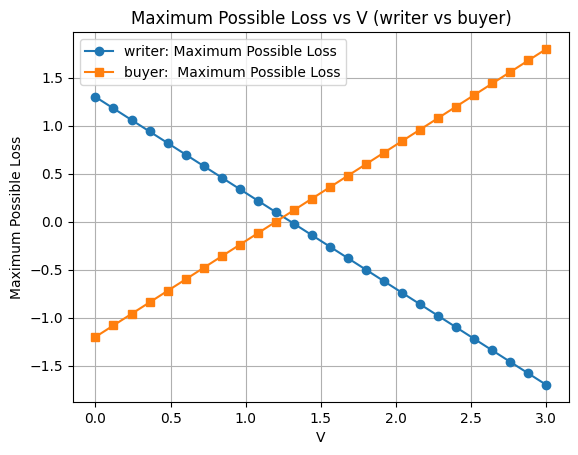

In [ ]:
# Σάρωση V στο [0, Vmax] και κοινό γράφημα writer/buyer.
import numpy as np
import matplotlib.pyplot as plt
import io, contextlib

# === Ρύθμιση διαστήματος V ===
Vmax = 3.0          # βάλε ό,τι θέλεις
num_points = 25     # πλήθος δειγμάτων (25 -> 26 σημεία από 0 έως Vmax)
Vs = np.linspace(0.0, Vmax, num_points + 1)

def _eval_maxloss(func, V):
    """Καλεί func(V) και επιστρέφει x[idx_maxloss] ως float.
    Παίζει με:
      - επιστροφή dict με κλειδί 'x'
      - επιστροφή αριθμού
      - μόνο print του x[idx_maxloss]
    Επιστρέφει (value, error_msg)."""
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        try:
            ret = func(V)
        except Exception as e:
            # κλείσε τυχόν plots που άνοιξαν
            plt.close('all')
            return np.nan, f"Exec error: {e}"

    # κλείσε τυχόν plots που άνοιξαν μέσα στη συνάρτηση
    plt.close('all')

    # 1) Αν γύρισε dict με 'x'
    try:
        if isinstance(ret, dict) and "x" in ret:
            return float(ret["x"][-1]), None
    except Exception:
        pass

    # 2) Αν γύρισε αριθμό ή array-like
    try:
        if ret is not None:
            # άμεσο float
            return float(ret), None
    except Exception:
        # ίσως ret είναι array-like και θες το τελευταίο
        try:
            return float(ret[-1]), None
        except Exception:
            pass

    # 3) Αν δεν επέστρεψε τίποτα, δοκίμασε να παρσάρεις από το stdout
    out = buf.getvalue().strip()
    try:
        # πάρε την τελευταία γραμμή και κάν’ την float
        last_line = out.splitlines()[-1] if out else ""
        return float(last_line), None
    except Exception:
        return np.nan, f"Could not parse output: {last_line[:120]}"

writer_maxloss = np.empty_like(Vs)
buyer_maxloss  = np.empty_like(Vs)

writer_errs = []
buyer_errs  = []

for i, V in enumerate(Vs):
    val_w, err_w = _eval_maxloss(run_options_milp_writer, V)
    val_b, err_b = _eval_maxloss(run_options_milp_buyer, -V)  # buyer πάντα -V

    writer_maxloss[i] = val_w
    buyer_maxloss[i]  = val_b

    if err_w: writer_errs.append((V, err_w))
    if err_b: buyer_errs.append((V, err_b))

# Αν όλα NaN, ενημέρωσε για διάγνωση
if not np.isfinite(writer_maxloss).any() and not np.isfinite(buyer_maxloss).any():
    print("Καμία πεπερασμένη τιμή δεν υπολογίστηκε. Πιθανοί λόγοι:")
    print("- Οι συναρτήσεις δεν επιστρέφουν αποτέλεσμα (μόνο print). Το παραπάνω κελί το χειρίζεται, άρα ίσως υπήρξε σφάλμα.")
    print("- Πολλά V δίνουν μη εφικτά προβλήματα (MILP infeasible). Δοκίμασε μικρότερο Vmax ή άλλα constraints.")
    if writer_errs or buyer_errs:
        print("\nΣφάλματα (δείγμα):")
        for V, msg in (writer_errs[:3] + buyer_errs[:3]):
            print(f"V={V}: {msg}")

# Φιλτράρισμα NaN για κάθε καμπύλη ώστε να σχεδιάζονται μόνο έγκυρα σημεία
mask_w = np.isfinite(writer_maxloss)
mask_b = np.isfinite(buyer_maxloss)

fig, ax = plt.subplots()
if mask_w.any():
    ax.plot(Vs[mask_w], writer_maxloss[mask_w], marker='o', label="writer: Maximum Possible Loss")
if mask_b.any():
    ax.plot(Vs[mask_b], buyer_maxloss[mask_b], marker='s', label="buyer:  Maximum Possible Loss")

ax.set_xlabel("V")
ax.set_ylabel("Maximum Possible Loss")
ax.set_title("Maximum Possible Loss vs V (writer vs buyer)")
ax.grid(True)
ax.legend()
plt.show()


We define a further function for the writer of option. The writer can make a prediction about the future price of the asset. Then the function computes the optimal portfolio with maximum possible loss $D$, using the amount $V$. You can call the function like this

res = run_options_milp_kmax_writer(D=2.0, V=3.5, KKmax=np.array([[6,0.5]], [12,0.5)).

The KKmax contain the predictions with some weight. For example the writer may predict that the value of the option will be near to $6$ with weight $0.5$ or near to $12$ with weight $0.5$. You can add as many predictions as you want.

In [3]:
def run_options_milp_kmax_writer(D, V, KKmax):
    import numpy as np

    ############################################
    number_of_Kmaxes = KKmax.shape[0]
    ###########################################

    #######################################################################################################################
    # Here is the function that download the data from yahoo finance
    def options_bid_ask(Firm,ExpirationDate,experiment):
        import numpy as np
        import yfinance as yt
        stock = yt.Ticker(Firm)
        stock_value = stock.history(period='1d')['Close'].iloc[-1]
        options_chain = stock.option_chain(ExpirationDate)
        call_strikes=options_chain.calls.strike.to_numpy()
        put_strikes=options_chain.puts.strike.to_numpy()
        if experiment==1:
           call_ask = options_chain.calls.lastPrice.to_numpy()
           call_bid=options_chain.calls.lastPrice.to_numpy()
           put_ask=options_chain.puts.lastPrice.to_numpy()
           put_bid=options_chain.puts.lastPrice.to_numpy()
        else:
           call_ask = options_chain.calls.ask.to_numpy()
           call_bid=options_chain.calls.bid.to_numpy()
           put_ask=options_chain.puts.ask.to_numpy()
           put_bid=options_chain.puts.bid.to_numpy()
        return stock_value, call_strikes,put_strikes,call_ask,call_bid,put_ask,put_bid
    ############################################################################################################


    ##################################################################################################
    # Here is the function that take the data from the excel file.
    def options_bid_ask_excel(experiment):
        import pandas as pd
        import numpy as np
        try:
            df = pd.read_excel(excel_file)
            stock_value = df.iloc[0, 0]
            call_strikes = df.iloc[:, 1].dropna().to_numpy()
            put_strikes = df.iloc[:, 5].dropna().to_numpy()
            if experiment==1:
                call_ask = df.iloc[:, 2].dropna().to_numpy()
                call_bid = df.iloc[:, 2].dropna().to_numpy()
                put_ask = df.iloc[:, 6].dropna().to_numpy()
                put_bid = df.iloc[:, 6].dropna().to_numpy()
            else:
                call_ask = df.iloc[:, 4].dropna().to_numpy()
                call_bid = df.iloc[:, 3].dropna().to_numpy()
                put_ask = df.iloc[:, 8].dropna().to_numpy()
                put_bid = df.iloc[:, 7].dropna().to_numpy()
            return stock_value, call_strikes,put_strikes,call_ask,call_bid,put_ask,put_bid
        except FileNotFoundError: # Added a basic except block to handle file not found errors
            print("Error: 'excel_file.xlsx' not found. Please make sure the file exists in the current directory.")
            return None, None, None, None, None, None, None # Return None values if file not found
    ####################################################################################################################


    ##########################################################################################
    # Here we choose how we collect the data
    if Data_given==1:
       stock_value, call_strikes,put_strikes,call_ask1,call_bid,put_ask1,put_bid=options_bid_ask(Firm,ExpirationDate,experiment)
    else:
       stock_value, call_strikes,put_strikes,call_ask1,call_bid,put_ask1,put_bid=options_bid_ask_excel(experiment)
    ###########################################################################################


    #########################################################################################
    # These data  are for experiments
    #stock_value=8
    #call_strikes=np.array([7,8])
    #put_strikes=np.array([7,8,9])
    #call_ask1=np.array([0,3])
    #call_bid=np.array([3.9,2.9])
    #put_ask1=np.array([3,4,5])
    #put_bid=np.array([2.9,3.9,4.9])
    ########################################################################################


    #####################################################################################
    # We will remove zeros from the ask prices
    keep_mask_call = call_ask1 != 0
    keep_mask_put = put_ask1 !=0
    call_ask = call_ask1[keep_mask_call]
    call_bid = call_bid[keep_mask_call]
    put_ask = put_ask1[keep_mask_put]
    put_bid = put_bid[keep_mask_put]
    call_strikes=call_strikes[keep_mask_call]
    put_strikes=put_strikes[keep_mask_put]
    #######################################################################################


    ###############################################################################################
    union_strikes1=np.union1d(call_strikes,put_strikes) #The union of call_strikes and put_strikes
    union_strikes=np.union1d(union_strikes1,payoff_nodes) # We add the payoff nodes
    max_element = union_strikes.max() # We need this for the plot
    ##########################################################################################


    #############################################################################################
    # This will give the row of the matrix A for each strike price.
    # The first element is the number of shares, next bank account, next call options to buy,
    # call options to sell, put options to buy, put options to sell and the Bank account
    def P(x):
        matrixrow = np.maximum(x - call_strikes, 0) #call to buy
        matrixrow = np.append(matrixrow, -np.maximum(x-call_strikes, 0)) # call to sell
        matrixrow=np.append(matrixrow, np.maximum(put_strikes-x, 0)) # put to buy
        matrixrow=np.append(matrixrow, -np.maximum(put_strikes-x, 0)) # put to sell
        matrixrow = np.append(x, matrixrow) # shares
        matrixrow = np.append(matrixrow, 1) # Bank account
        return matrixrow
        # We will add some more elements depending on KKmax
    def PP(x):
        (number_of_Kmaxes_local,weights)=np.shape(KKmax)
        matrixrow=P(x)
        for i in range(1,number_of_Kmaxes_local+1):
            matrixrow=np.append(matrixrow,0)
        return matrixrow
    ###############################################################################################

    ###########################################################################################
    # We begin to set the matrix AA
    AA = PP(0)
    number_of_columns_AA = AA.shape[0]
    for x in union_strikes:
        AA=np.vstack([AA, PP(x)])
    AA = -AA
    ############################################################################################

    ##########################################################################################
    # Adding the row with the derivative
    Aderiv = np.zeros(number_of_columns_AA)
    for i in range(0,len(call_strikes)+1):
        Aderiv[i] = -1
    for i in range(len(call_strikes)+1, 2*len(call_strikes)+1):
        Aderiv[i] = 1
    AA = np.vstack([AA, Aderiv])
    ############################################################################################


    ###########################################################################################
    #  Adding the rows for the Kmaxes
    for i in range(0,number_of_Kmaxes):
        AAKmax=PP(KKmax[i,0])
        AAKmax[2*len(call_strikes)+2*len(put_strikes)+2+i]=-1
        AA=np.vstack([AA, -AAKmax])
    ############################################################################################

    ###########################################################################################
    # Adding the row with options prices
    Aequality=call_ask
    Aequality=np.append(Aequality,-call_bid)
    Aequality=np.append(Aequality,put_ask)
    Aequality=np.append(Aequality,-put_bid)
    Aequality=np.append(stock_value,Aequality)
    Aequality=np.append(Aequality,1) # Bank acoount
    Kmaxeszeros=np.zeros(number_of_Kmaxes)
    Aequality=np.append(Aequality,Kmaxeszeros)
    AA=np.vstack([AA,Aequality])
    #############################################################################################


    ############################################################################################
    # Adding the rows for the maximum number of options
    Amaxnumberoptions_call_buy=np.full(number_of_columns_AA,0)
    Amxanumberoptions_call_sell=np.full(number_of_columns_AA,0)
    Amaxnumberoptions_put_buy=np.full(number_of_columns_AA,0)
    Amaxnumberoptions_put_sell=np.full(number_of_columns_AA,0)
    for i in range(1,len(call_strikes)+1):
        Amaxnumberoptions_call_buy[i]=1
    for i in range(len(call_strikes)+1,2*len(call_strikes)+1):
        Amxanumberoptions_call_sell[i]=1
    for i in range(2*len(call_strikes)+1,2*len(call_strikes)+len(put_strikes)+1):
        Amaxnumberoptions_put_buy[i]=1
    for i in range(2*len(call_strikes)+len(put_strikes)+1,2*len(call_strikes)+2*len(put_strikes)+1):
        Amaxnumberoptions_put_sell[i]=1
    AA=np.vstack([AA,Amaxnumberoptions_call_buy])
    AA=np.vstack([AA,Amxanumberoptions_call_sell])
    AA=np.vstack([AA,Amaxnumberoptions_put_buy])
    AA=np.vstack([AA,Amaxnumberoptions_put_sell])
    ###############################################################################################


    ######################################################################################
    # Setting the right hand side for the writer
    bw = np.zeros(AA.shape[0])
    bw[0]=D-payoff_function(0)
    for i in range(1,len(union_strikes)+1):
           bw[i] = D - payoff_function(union_strikes[i-1]) # For the writer this should be (-)
    for i in range(len(union_strikes)+2,len(union_strikes)+2+number_of_Kmaxes):
        bw[i]  =-  payoff_function(KKmax[i-len(union_strikes)-2,0])
    bw[-4]=max_number_of_total_call_options_to_buy
    bw[-3]=max_number_of_total_call_options_to_sell
    bw[-2]=max_number_of_total_put_options_to_buy
    bw[-1]=max_number_of_total_put_options_to_sell
    bw[len(union_strikes)+1]=-derivative_of_payoff # for the row with the derivatives
    bw[-5]=V
    ######################################################################################



    ####################################################################
    # Setting the left hand side
    bl=np.full_like(bw, -np.inf, dtype=float)
    bl[-5]=V
    ###################################################################

    #######################################################################
    # Setting the upper bounds for the parameters
    ub=np.full(AA.shape[1], 0, dtype=float)
    ub[-number_of_Kmaxes:]=np.inf
    ub[-number_of_Kmaxes-1]=max_amount_to_bank_account
    ub[0]=max_number_of_shares_to_buy
    for i in range(1,len(call_strikes)+1):
            ub[i]=max_number_of_call_options_to_buy
    for i in range(2*len(call_strikes)+1,2*len(call_strikes)+len(put_strikes)+1):
            ub[i]=max_number_of_put_options_to_buy
    for i in range(len(call_strikes)+1,2*len(call_strikes)+1):
            ub[i]=max_number_of_call_options_to_sell
    for i in range(2*len(call_strikes)+len(put_strikes)+1,2*len(call_strikes)+2*len(put_strikes)+1):
            ub[i]=max_number_of_put_options_to_sell
    ########################################################################


    ###################################################################
    # Setting the lower bounds for the parameters
    lb=np.full(AA.shape[1], 0, dtype=float)
    lb[0]=-max_number_of_shares_to_sell
    lb[-number_of_Kmaxes-1]=-max_amount_from_bank_account # bank account
    ###################################################################



    ###########################################################################
    # We assume that we can buy  only integer number of options
    integrality=np.full(AA.shape[1],1)
    integrality[0]=0 # 1 for integer number of shares, 0 for fractional number of shares
    integrality[-number_of_Kmaxes:]=0
    integrality[-number_of_Kmaxes-1]=0 # bank account
    ############################################################################


    ###################################################################
    # We define the constraints and the bounds
    from scipy.optimize import LinearConstraint
    constraints=LinearConstraint(AA,bl,bw)
    from scipy.optimize import Bounds
    bounds=Bounds(lb,ub)
    ###################################################################


    #########################################################################
    # We set the quantity to be minimized
    f=np.zeros(AA.shape[1])
    f[-number_of_Kmaxes:]=-KKmax[:,1]
    ########################################################################



    #########################################################################
    # We solve the optimization problem
    from scipy.optimize import milp
    result = milp(c=f, constraints=constraints, integrality=integrality, bounds=bounds)
    print(result)
    x = result.x
    ###########################################################################

    #################################################################################
    # We construct the table of results
    from prettytable import PrettyTable
    t = PrettyTable(['Shares', 'Number of Shares', 'Price', 'Amount for Shares'])
    t.add_row([Firm, x[0], stock_value, x[0]*stock_value])
    print(t)
    tt=PrettyTable(['Type of Option', 'Strike Price', 'Number of Options', 'Price of each Option'   ])
    for i in range(1,len(call_strikes)+1):
        if x[i] > 0.01:
           tt.add_row(['Call', call_strikes[i-1], round(x[i]), call_ask[i-1] ])
    for i in range(len(call_strikes)+1,2*len(call_strikes)+1):
        if x[i] > 0.01:
           tt.add_row(['Call', call_strikes[i-len(call_strikes)-1], -round(x[i]), call_bid[i-len(call_strikes)-1] ])
    for i in range(2*len(call_strikes)+1, 2*len(call_strikes)+1+len(put_strikes)):
        if x[i] > 0.01:
           tt.add_row(['Put', put_strikes[i-2*len(call_strikes)-1], round(x[i]), put_ask[i-2*len(call_strikes)-1]])
    for i in range(2*len(call_strikes)+1+len(put_strikes), 2*len(call_strikes)+2*len(put_strikes)+1):
        if x[i] > 0.01:
           tt.add_row(['Put', put_strikes[i-2*len(call_strikes)-1-len(put_strikes)-1], -round(x[i]), put_bid[i-2*len(call_strikes)-1-len(put_strikes)-1]])
    tt.add_divider()
    tt.add_row(['Bank Account','--', '--',x[-number_of_Kmaxes-1],])
    tt.add_divider()
    tt.add_row(['Total amount','--', '--',np.dot(AA[-5,:],x),])
    tt._align['Number of Options'] = 'r'
    print(tt)
    #######################################################################################################

    ################################################################################################
    # We define the profit function
    def profit_function(y):
        value = x[0]*y+x[-number_of_Kmaxes-1]
        for i in range(1,2*len(call_strikes)+2*len(put_strikes)+1):
            if x[i] > 0.01:
               value+=x[i]*PP(y)[i]
        value=value-payoff_function(y)
        return value # Return the calculated value
    ################################################################################################



    ###################################################################################
    # We plot the profit function
    import matplotlib.pyplot as plt
    # Generate y values for the plot
    ymax=max_element*1.2
    y_values = np.linspace(0, ymax, 500)  # Adjust range as needed
    # Calculate profit for each y value
    profit_values = [profit_function(y) for y in y_values]
    # Plot the profit function
    # Get the current axes
    ax = plt.gca()
    # Plot the profit function
    ax.plot(y_values, profit_values)
    ax.set_xlabel("Stock Price") # Use ax.set_xlabel instead of plt.xlabel
    ax.set_ylabel("Profit") # Use ax.set_ylabel instead of plt.ylabel
    ax.set_title(f"Profit Function.") # Use ax.set_title instead of plt.title
    ax.grid(True)
    ax.axhline(0, color='black', linewidth=1.5, linestyle='--')
    ax.fill_between(y_values, profit_values, 0, where=np.array(profit_values) > 0, color='green', alpha=0.3, label='Περιοχή y > 0')
    ax.fill_between(y_values, profit_values, 0, where=np.array(profit_values) < 0, color='red', alpha=0.3, label='Περιοχή y < 0')
    ##############################################################################################################################


        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -4.750000190734852
              x: [-4.000e+00  0.000e+00 ...  9.530e+01  9.500e+00]
 mip_node_count: 390
 mip_dual_bound: -4.7504546399576375
        mip_gap: 9.567351674469835e-05
+--------+--------------------+-------------------+---------------------+
| Shares |  Number of Shares  |       Price       |  Amount for Shares  |
+--------+--------------------+-------------------+---------------------+
|  HTZ   | -4.000000000000001 | 6.400000095367432 | -25.600000381469734 |
+--------+--------------------+-------------------+---------------------+
+----------------+--------------+-------------------+----------------------+
| Type of Option | Strike Price | Number of Options | Price of each Option |
+----------------+--------------+-------------------+----------------------+
|      Call      |     1.0      |                 1 |         4.9          |


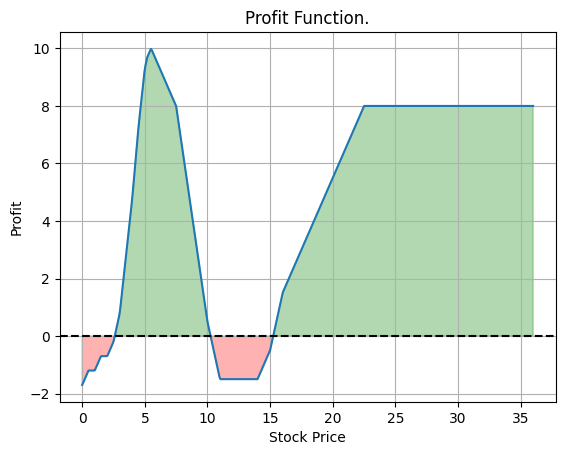

In [12]:
# Ορίζεις ΟΛΑ τα υπόλοιπα σταθερά όπως ήδη κάνεις (Data_given, Firm, payoff_function, κ.λπ.)
# και ΑΠΛΩΣ καλείς:
res = run_options_milp_kmax_writer(D=2.0, V=3.5, KKmax=np.array([[6,0.5]]))


Below we give a similar function for the buyer.

In [13]:
def run_options_milp_kmax_buyer(D, V, KKmax):
    import numpy as np

    #######################################################################################################################
    # Here is the function that download the data from yahoo finance
    def options_bid_ask(Firm,ExpirationDate,experiment):
        import numpy as np
        import yfinance as yt
        stock = yt.Ticker(Firm)
        stock_value = stock.history(period='1d')['Close'].iloc[-1]
        options_chain = stock.option_chain(ExpirationDate)
        call_strikes=options_chain.calls.strike.to_numpy()
        put_strikes=options_chain.puts.strike.to_numpy()
        if experiment==1:
           call_ask = options_chain.calls.lastPrice.to_numpy()
           call_bid=options_chain.calls.lastPrice.to_numpy()
           put_ask=options_chain.puts.lastPrice.to_numpy()
           put_bid=options_chain.puts.lastPrice.to_numpy()
        else:
           call_ask = options_chain.calls.ask.to_numpy()
           call_bid=options_chain.calls.bid.to_numpy()
           put_ask = options_chain.puts.ask.to_numpy()
           put_bid = options_chain.puts.bid.to_numpy()
        return stock_value, call_strikes,put_strikes,call_ask,call_bid,put_ask,put_bid
    ############################################################################################################

    ##################################################################################################
    # Here is the function that take the data from the excel file.
    def options_bid_ask_excel(experiment):
        import pandas as pd
        import numpy as np
        try:
            df = pd.read_excel(excel_file)
            stock_value = df.iloc[0, 0]
            call_strikes = df.iloc[:, 1].dropna().to_numpy()
            put_strikes = df.iloc[:, 5].dropna().to_numpy()
            if experiment==1:
                call_ask = df.iloc[:, 2].dropna().to_numpy()
                call_bid = df.iloc[:, 2].dropna().to_numpy()
                put_ask = df.iloc[:, 6].dropna().to_numpy()
                put_bid = df.iloc[:, 6].dropna().to_numpy()
            else:
                call_ask = df.iloc[:, 4].dropna().to_numpy()
                call_bid = df.iloc[:, 3].dropna().to_numpy()
                put_ask = df.iloc[:, 8].dropna().to_numpy()
                put_bid = df.iloc[:, 7].dropna().to_numpy()
            return stock_value, call_strikes,put_strikes,call_ask,call_bid,put_ask,put_bid
        except FileNotFoundError:
            print("Error: 'excel_file.xlsx' not found. Please make sure the file exists in the current directory.")
            return None, None, None, None, None, None, None
    ####################################################################################################################

    ############################################
    number_of_Kmaxes = KKmax.shape[0]
    ###########################################

    ##########################################################################################
    # Here we choose how we collect the data
    if Data_given==1:
       stock_value, call_strikes,put_strikes,call_ask1,call_bid,put_ask1,put_bid=options_bid_ask(Firm,ExpirationDate,experiment)
    else:
       stock_value, call_strikes,put_strikes,call_ask1,call_bid,put_ask1,put_bid=options_bid_ask_excel(experiment)
    ###########################################################################################

    #########################################################################################
    # These data  are for experiments
    #stock_value=8
    #call_strikes=np.array([7,8])
    #put_strikes=np.array([7,8,9])
    #call_ask1=np.array([0,3])
    #call_bid=np.array([3.9,2.9])
    #put_ask1=np.array([3,4,5])
    #put_bid=np.array([2.9,3.9,4.9])
    ########################################################################################

    #####################################################################################
    # We will remove zeros from the ask prices
    keep_mask_call = call_ask1 != 0
    keep_mask_put = put_ask1 !=0
    call_ask = call_ask1[keep_mask_call]
    call_bid = call_bid[keep_mask_call]
    put_ask = put_ask1[keep_mask_put]
    put_bid = put_bid[keep_mask_put]
    call_strikes=call_strikes[keep_mask_call]
    put_strikes=put_strikes[keep_mask_put]
    #######################################################################################

    ###############################################################################################
    union_strikes1=np.union1d(call_strikes,put_strikes) #The union of call_strikes and put_strikes
    union_strikes=np.union1d(union_strikes1,payoff_nodes) # We add the payoff nodes
    max_element = union_strikes.max() # We need this for the plot
    ##########################################################################################

    #############################################################################################
    # This will give the row of the matrix A for each strike price.
    # The first element is the number of shares, next bank account, next call options to buy,
    # call options to sell, put options to buy, put options to sell and the Bank account
    def P(x):
        matrixrow = np.maximum(x - call_strikes, 0) #call to buy
        matrixrow = np.append(matrixrow, -np.maximum(x-call_strikes, 0)) # call to sell
        matrixrow=np.append(matrixrow, np.maximum(put_strikes-x, 0)) # put to buy
        matrixrow=np.append(matrixrow, -np.maximum(put_strikes-x, 0)) # put to sell
        matrixrow = np.append(x, matrixrow) # shares
        matrixrow = np.append(matrixrow, 1) # Bank account
        return matrixrow
        # We will add some more elements depending on KKmax
    def PP(x):
        (number_of_Kmaxes_local,weights)=np.shape(KKmax)
        matrixrow=P(x)
        for i in range(1,number_of_Kmaxes_local+1):
            matrixrow=np.append(matrixrow,0)
        return matrixrow
    ###############################################################################################

    ###########################################################################################
    # We begin to set the matrix AA
    AA = PP(0)
    number_of_columns_AA = AA.shape[0]
    for x in union_strikes:
        AA=np.vstack([AA, PP(x)])
    AA = -AA
    ############################################################################################

    ##########################################################################################
    # Adding the row with the derivative
    Aderiv = np.zeros(number_of_columns_AA)
    for i in range(0,len(call_strikes)+1):
        Aderiv[i] = -1
    for i in range(len(call_strikes)+1, 2*len(call_strikes)+1):
        Aderiv[i] = 1
    AA = np.vstack([AA, Aderiv])
    ############################################################################################

    ###########################################################################################
    #  Adding the rows for the Kmaxes
    for i in range(0,number_of_Kmaxes):
        AAKmax=PP(KKmax[i,0])
        AAKmax[2*len(call_strikes)+2*len(put_strikes)+2+i]=-1
        AA=np.vstack([AA, -AAKmax])
    ############################################################################################

    ###########################################################################################
    # Adding the row with options prices
    Aequality=call_ask
    Aequality=np.append(Aequality,-call_bid)
    Aequality=np.append(Aequality,put_ask)
    Aequality=np.append(Aequality,-put_bid)
    Aequality=np.append(stock_value,Aequality)
    Aequality=np.append(Aequality,1) # Bank acoount
    Kmaxeszeros=np.zeros(number_of_Kmaxes)
    Aequality=np.append(Aequality,Kmaxeszeros)
    AA=np.vstack([AA,Aequality])
    #############################################################################################

    ############################################################################################
    # Adding the rows for the maximum number of options
    Amaxnumberoptions_call_buy=np.full(number_of_columns_AA,0)
    Amxanumberoptions_call_sell=np.full(number_of_columns_AA,0)
    Amaxnumberoptions_put_buy=np.full(number_of_columns_AA,0)
    Amaxnumberoptions_put_sell=np.full(number_of_columns_AA,0)
    for i in range(1,len(call_strikes)+1):
        Amaxnumberoptions_call_buy[i]=1
    for i in range(len(call_strikes)+1,2*len(call_strikes)+1):
        Amxanumberoptions_call_sell[i]=1
    for i in range(2*len(call_strikes)+1,2*len(call_strikes)+len(put_strikes)+1):
        Amaxnumberoptions_put_buy[i]=1
    for i in range(2*len(call_strikes)+len(put_strikes)+1,2*len(call_strikes)+2*len(put_strikes)+1):
        Amaxnumberoptions_put_sell[i]=1
    AA=np.vstack([AA,Amaxnumberoptions_call_buy])
    AA=np.vstack([AA,Amxanumberoptions_call_sell])
    AA=np.vstack([AA,Amaxnumberoptions_put_buy])
    AA=np.vstack([AA,Amaxnumberoptions_put_sell])
    ###############################################################################################

    ######################################################################################
    # Setting the right hand side for the writer (buyer-μορφή όπως δόθηκε)
    bw = np.zeros(AA.shape[0])
    bw[0]=D+payoff_function(0)
    for i in range(1,len(union_strikes)+1):
           bw[i] = D + payoff_function(union_strikes[i-1])
    for i in range(len(union_strikes)+2,len(union_strikes)+2+number_of_Kmaxes):
        bw[i]  =  payoff_function(KKmax[i-len(union_strikes)-2,0])
    bw[-4]=max_number_of_total_call_options_to_buy
    bw[-3]=max_number_of_total_call_options_to_sell
    bw[-2]=max_number_of_total_put_options_to_buy
    bw[-1]=max_number_of_total_put_options_to_sell
    bw[len(union_strikes)+1]=derivative_of_payoff
    bw[-5]=-V
    ######################################################################################

    ####################################################################
    # Setting the left hand side
    bl=np.full_like(bw, -np.inf, dtype=float)
    bl[-5]=-V
    ###################################################################

    #######################################################################
    # Setting the upper bounds for the parameters
    ub=np.full(AA.shape[1], 0, dtype=float)
    ub[-number_of_Kmaxes:]=np.inf
    ub[-number_of_Kmaxes-1]=max_amount_to_bank_account
    ub[0]=max_number_of_shares_to_buy
    for i in range(1,len(call_strikes)+1):
            ub[i]=max_number_of_call_options_to_buy
    for i in range(2*len(call_strikes)+1,2*len(call_strikes)+len(put_strikes)+1):
            ub[i]=max_number_of_put_options_to_buy
    for i in range(len(call_strikes)+1,2*len(call_strikes)+1):
            ub[i]=max_number_of_call_options_to_sell
    for i in range(2*len(call_strikes)+len(put_strikes)+1,2*len(call_strikes)+2*len(put_strikes)+1):
            ub[i]=max_number_of_put_options_to_sell
    ########################################################################

    ###################################################################
    # Setting the lower bounds for the parameters
    lb=np.full(AA.shape[1], 0, dtype=float)
    lb[0]=-max_number_of_shares_to_sell
    lb[-number_of_Kmaxes-1]=-max_amount_from_bank_account # bank account
    ###################################################################

    ###########################################################################
    # We assume that we can buy  only integer number of options
    integrality=np.full(AA.shape[1],1)
    integrality[0]=0 # 1 for integer number of shares, 0 for fractional number of shares
    integrality[-number_of_Kmaxes:]=0
    integrality[-number_of_Kmaxes-1]=0 # bank account
    ############################################################################

    ###################################################################
    # We define the constraints and the bounds
    from scipy.optimize import LinearConstraint
    constraints=LinearConstraint(AA,bl,bw)
    from scipy.optimize import Bounds
    bounds=Bounds(lb,ub)
    ###################################################################

    #########################################################################
    # We set the quantity to be minimized
    f=np.zeros(AA.shape[1])
    f[-number_of_Kmaxes:]=-KKmax[:,1]
    ########################################################################

    #########################################################################
    # We solve the optimization problem
    from scipy.optimize import milp
    result = milp(c=f, constraints=constraints, integrality=integrality, bounds=bounds)
    print(result)
    x = result.x
    ###########################################################################

    #################################################################################
    # We construct the table of results
    from prettytable import PrettyTable
    t = PrettyTable(['Shares', 'Number of Shares', 'Price', 'Amount for Shares'])
    t.add_row([Firm, x[0], stock_value, x[0]*stock_value])
    print(t)
    tt=PrettyTable(['Type of Option', 'Strike Price', 'Number of Options', 'Price of each Option'   ])
    for i in range(1,len(call_strikes)+1):
        if x[i] > 0.01:
           tt.add_row(['Call', call_strikes[i-1], round(x[i]), call_ask[i-1] ])
    for i in range(len(call_strikes)+1,2*len(call_strikes)+1):
        if x[i] > 0.01:
           tt.add_row(['Call', call_strikes[i-len(call_strikes)-1], -round(x[i]), call_bid[i-len(call_strikes)-1] ])
    for i in range(2*len(call_strikes)+1, 2*len(call_strikes)+1+len(put_strikes)):
        if x[i] > 0.01:
           tt.add_row(['Put', put_strikes[i-2*len(call_strikes)-1], round(x[i]), put_ask[i-2*len(call_strikes)-1]])
    for i in range(2*len(call_strikes)+1+len(put_strikes), 2*len(call_strikes)+2*len(put_strikes)+1):
        if x[i] > 0.01:
           tt.add_row(['Put', put_strikes[i-2*len(call_strikes)-1-len(put_strikes)-1], -round(x[i]), put_bid[i-2*len(call_strikes)-1-len(put_strikes)-1]])
    tt.add_divider()
    tt.add_row(['Bank Account','--', '--',x[-number_of_Kmaxes-1],])
    tt.add_divider()
    tt.add_row(['Total amount','--', '--',np.dot(AA[-5,:],x),])
    tt._align['Number of Options'] = 'r'
    print(tt)
    #######################################################################################################

    ################################################################################################
    # We define the profit function
    def profit_function(y):
        value = x[0]*y+x[-number_of_Kmaxes-1]
        for i in range(1,2*len(call_strikes)+2*len(put_strikes)+1):
            if x[i] > 0.01:
               value+=x[i]*PP(y)[i]
        value=value+payoff_function(y)
        return value # Return the calculated value
    ################################################################################################

    ###################################################################################
    # We plot the profit function
    import matplotlib.pyplot as plt
    ymax=max_element*1.2
    y_values = np.linspace(0, ymax, 500)
    profit_values = [profit_function(y) for y in y_values]
    ax = plt.gca()
    ax.plot(y_values, profit_values)
    ax.set_xlabel("Stock Price")
    ax.set_ylabel("Profit")
    ax.set_title(f"Profit Function.")
    ax.grid(True)
    ax.axhline(0, color='black', linewidth=1.5, linestyle='--')
    ax.fill_between(y_values, profit_values, 0, where=np.array(profit_values) > 0, color='green', alpha=0.3, label='Περιοχή y > 0')
    ax.fill_between(y_values, profit_values, 0, where=np.array(profit_values) < 0, color='red', alpha=0.3, label='Περιοχή y < 0')


        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -2.636956777509539
              x: [-4.935e+00  0.000e+00 ...  9.708e+01  5.274e+00]
 mip_node_count: 1280
 mip_dual_bound: -2.6371195397614287
        mip_gap: 6.172351904960811e-05
+--------+--------------------+-------------------+---------------------+
| Shares |  Number of Shares  |       Price       |  Amount for Shares  |
+--------+--------------------+-------------------+---------------------+
|  HTZ   | -4.934782711003816 | 6.400000095367432 | -31.582609821041977 |
+--------+--------------------+-------------------+---------------------+
+----------------+--------------+-------------------+----------------------+
| Type of Option | Strike Price | Number of Options | Price of each Option |
+----------------+--------------+-------------------+----------------------+
|      Call      |     1.0      |                 1 |         4.9          |

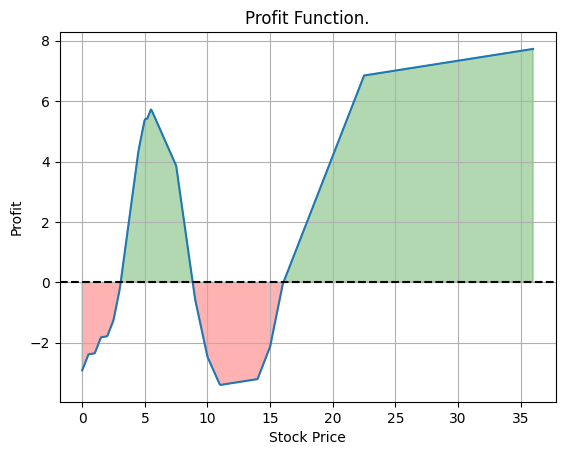

In [15]:
# Ρύθμισε ΟΛΑ τα υπόλοιπα (Data_given, Firm, ExpirationDate, payoff_function, κ.λπ.) όπως ήδη κάνεις
# και κάλεσε:
run_options_milp_kmax_buyer(D=3.4, V=3.4, KKmax=np.array([[6,0.5]]))
